In [1]:
# Cell 1: Import Libraries
# Standard data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve
)

# Feature engineering and anomaly detection
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Model interpretability
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [2]:
!pip install shap

In [3]:
# Cell 2: Load and Prepare Data
# Load the dataset
df = pd.read_csv('parkinson_disease.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check class distribution
print("\nClass distribution:")
print(df['class'].value_counts())

Dataset shape: (756, 755)

First 5 rows:


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1



Missing values per column:
id                           0
gender                       0
PPE                          0
DFA                          0
RPDE                         0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 755, dtype: int64

Class distribution:
class
1    564
0    192
Name: count, dtype: int64


In [4]:
# Cell 3: Data Preprocessing
# Remove duplicates
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

# Handle outliers
print("\nHandling outliers...")
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df.select_dtypes(include=[np.number]))
df = df[outliers == 1]
print("Shape after removing outliers:", df.shape)

# Separate features and target
X = df.drop(['id', 'class'], axis=1)
y = df['class']

# Encode gender if needed
if 'gender' in X.columns:
    X['gender'] = X['gender'].astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preprocessing completed!")

Shape after removing duplicates: (755, 755)

Handling outliers...
Shape after removing outliers: (747, 755)

Data preprocessing completed!


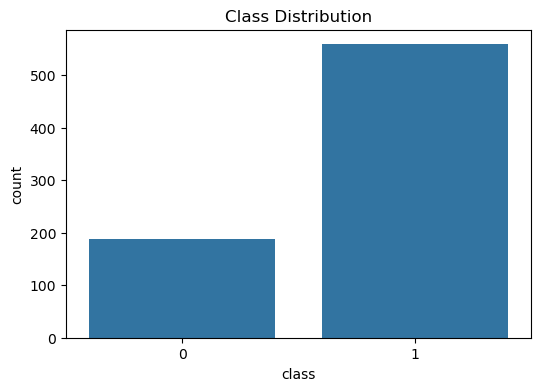

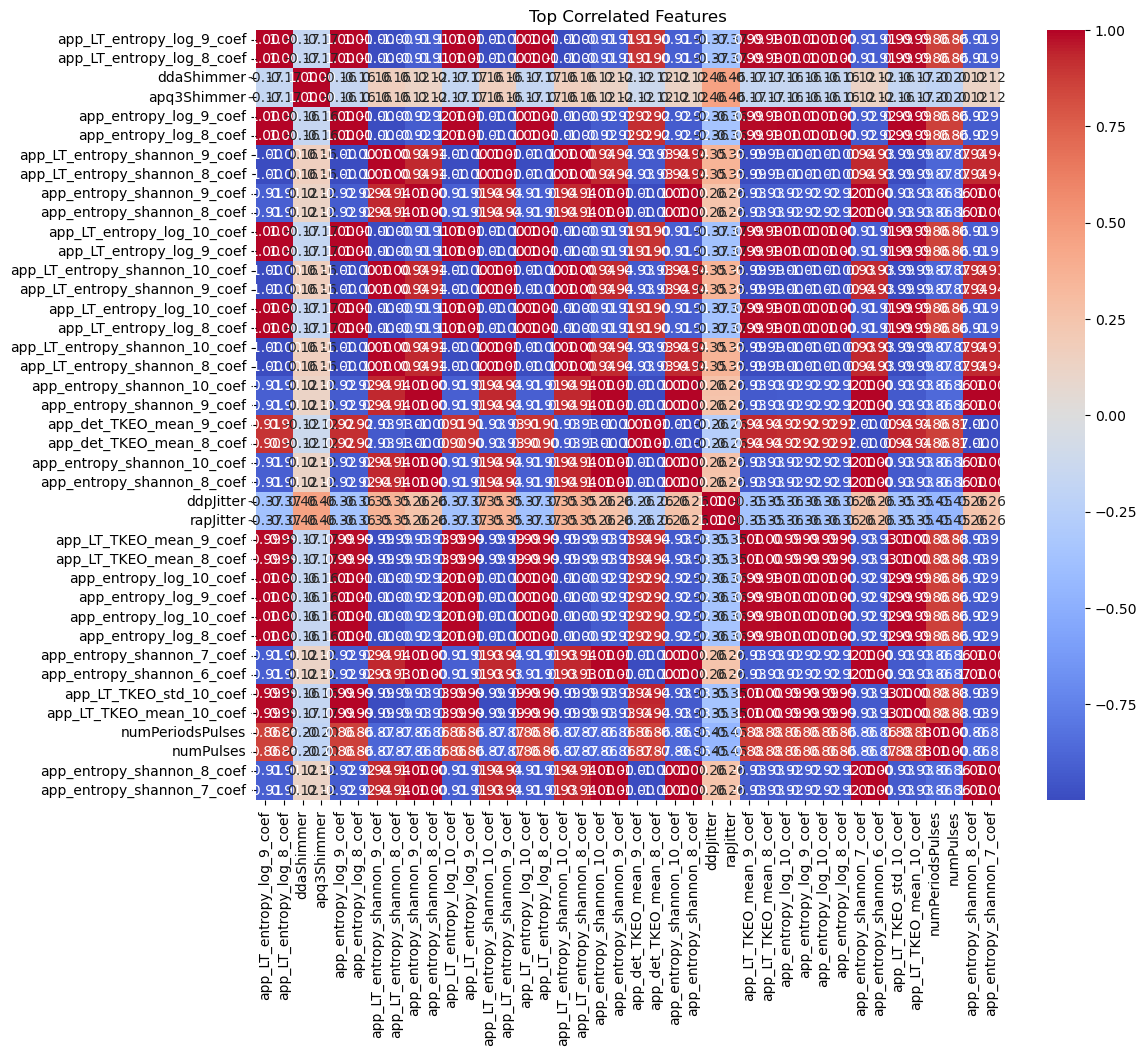

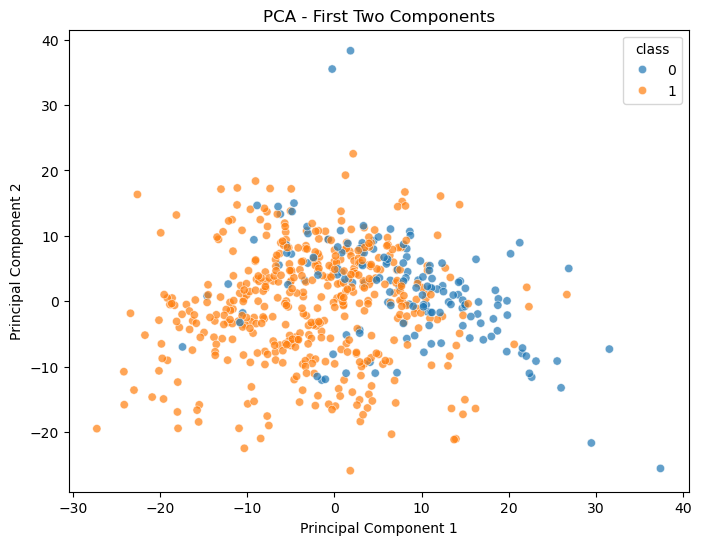

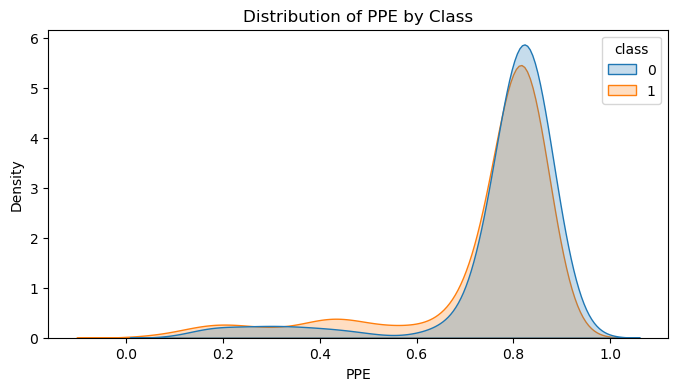

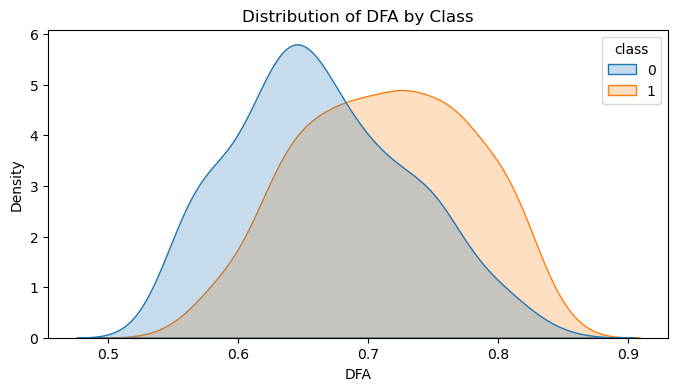

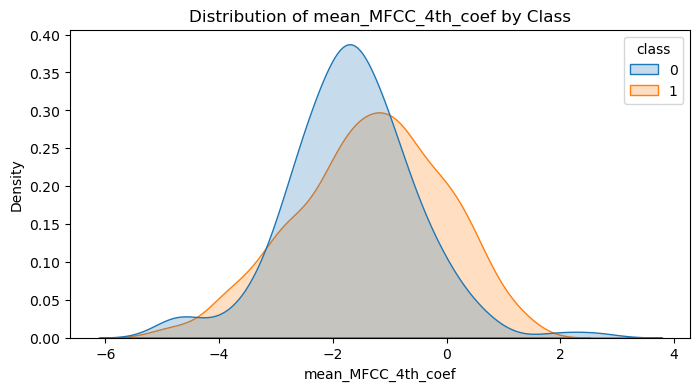

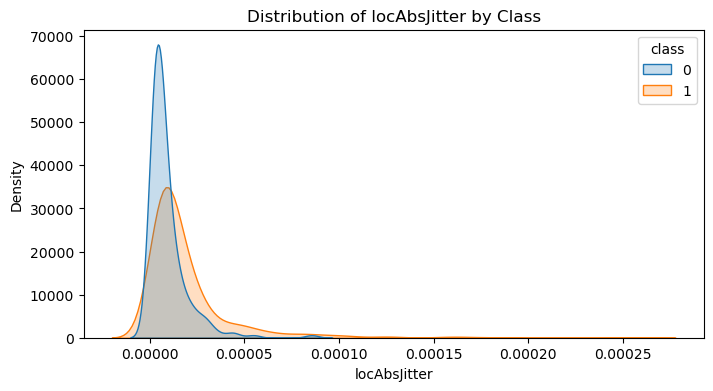

In [5]:
# Cell 4: Exploratory Data Analysis (EDA)
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()

# Correlation heatmap (top 20 features)
plt.figure(figsize=(12,10))
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_features = upper.unstack().sort_values(ascending=False)[:20].index.tolist()
top_feature_pairs = [(i[0], i[1]) for i in top_features]
sns.heatmap(X_train[[col for pair in top_feature_pairs for col in pair]].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlated Features')
plt.show()

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, alpha=0.7)
plt.title('PCA - First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Feature distributions by class
for feature in ['PPE', 'DFA', 'mean_MFCC_4th_coef', 'locAbsJitter']:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df, x=feature, hue='class', fill=True, common_norm=False)
    plt.title(f'Distribution of {feature} by Class')
    plt.show()


Training Logistic Regression...


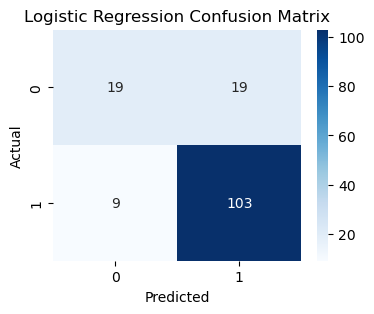

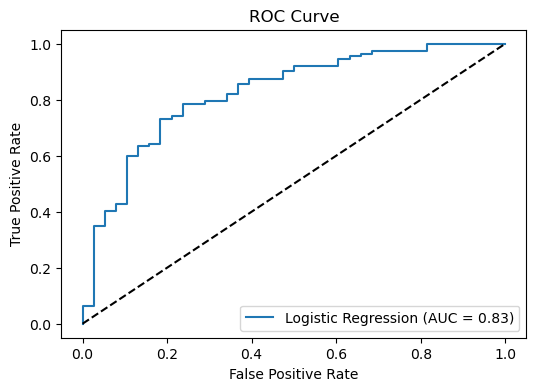


Training Random Forest...


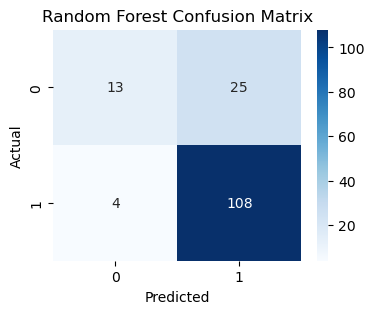

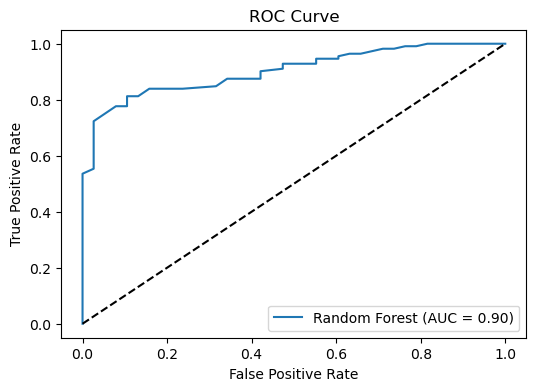


Training XGBoost...


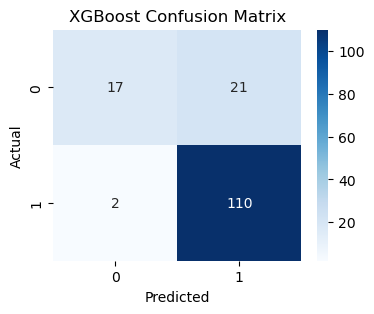

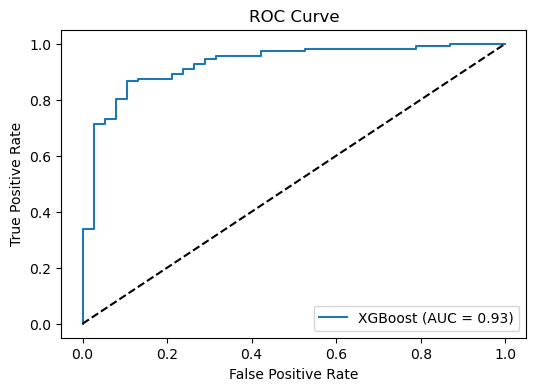


Training SVM...


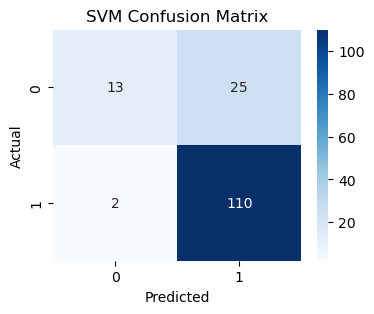

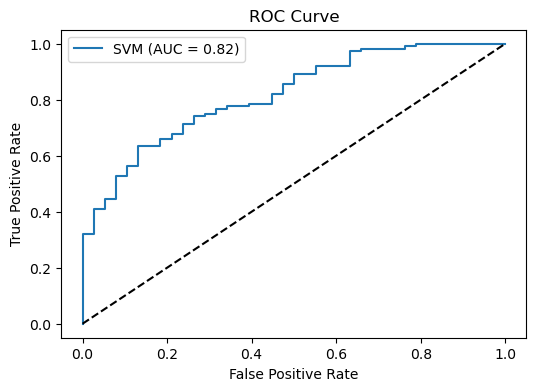


Training Neural Network...


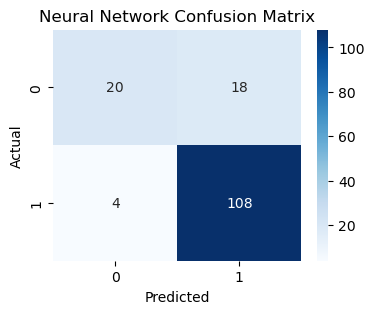

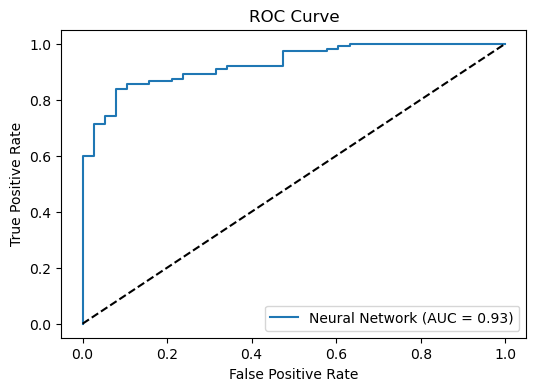


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1,ROC-AUC,CV Mean,CV Std
0,Logistic Regression,0.813333,0.844262,0.919643,0.880342,0.825423,0.847605,0.016714
1,Random Forest,0.806667,0.812030,0.964286,0.881633,0.902961,0.877801,0.034264
2,XGBoost,0.846667,0.839695,0.982143,0.905350,0.928102,0.869370,0.021475
3,SVM,0.820000,0.814815,0.982143,0.890688,0.818139,0.867717,0.016733
4,Neural Network,0.853333,0.857143,0.964286,0.907563,0.928102,0.882759,0.020481


In [6]:
# Cell 5: Model Training and Evaluation
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64,32), 
                                  max_iter=1000, random_state=42)
}

# Train and evaluate models
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
display(results_df)

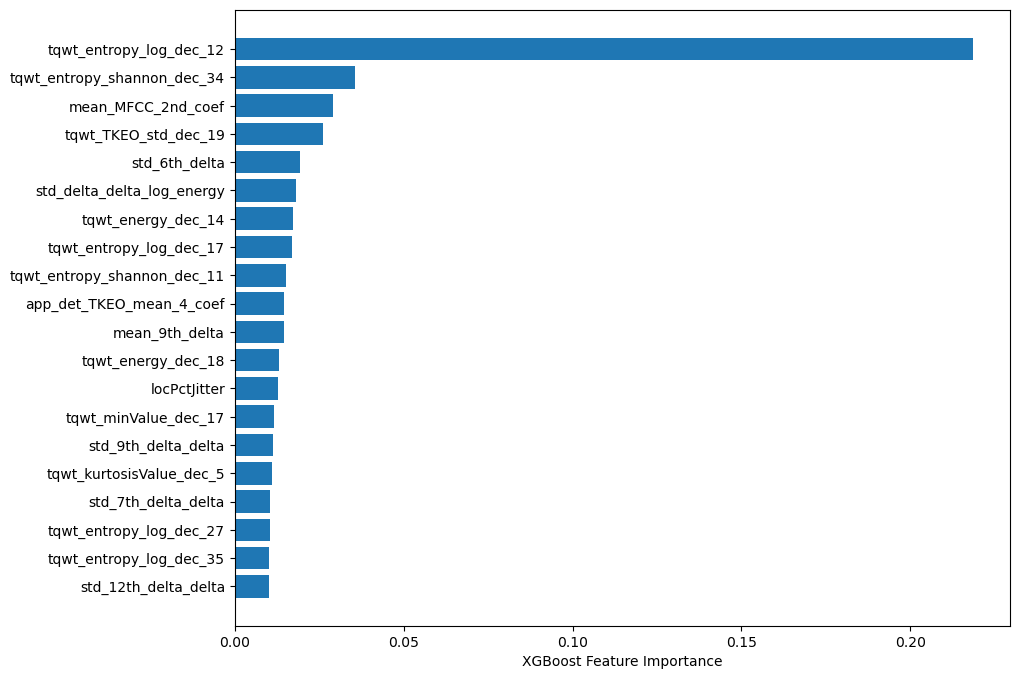


Calculating SHAP values... (this may take a few minutes)


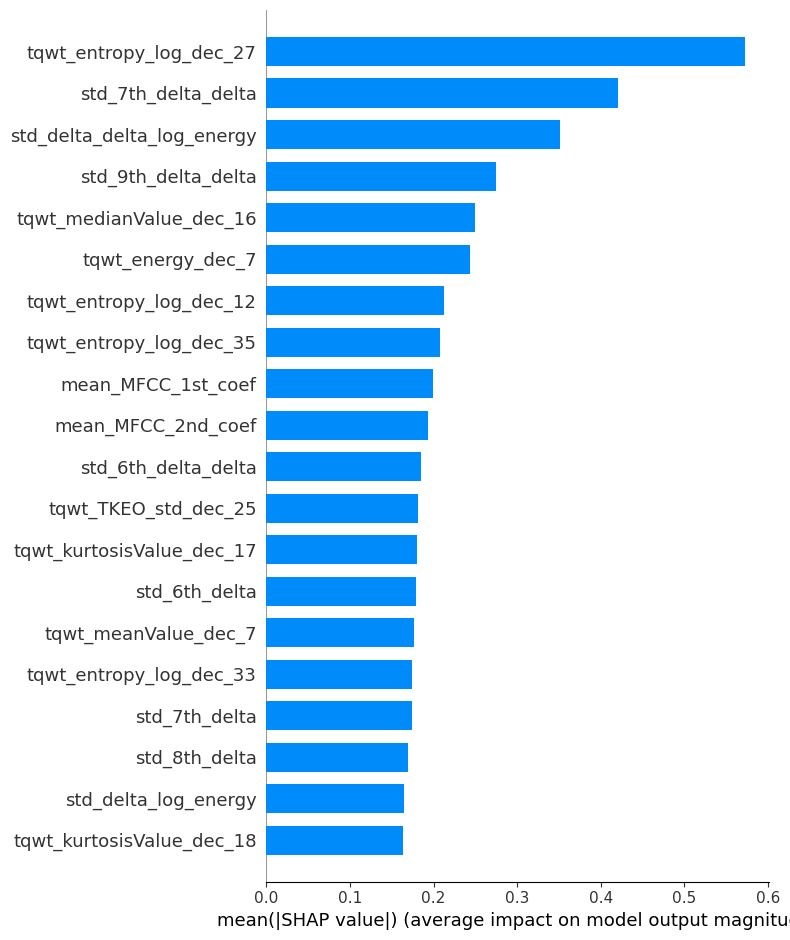

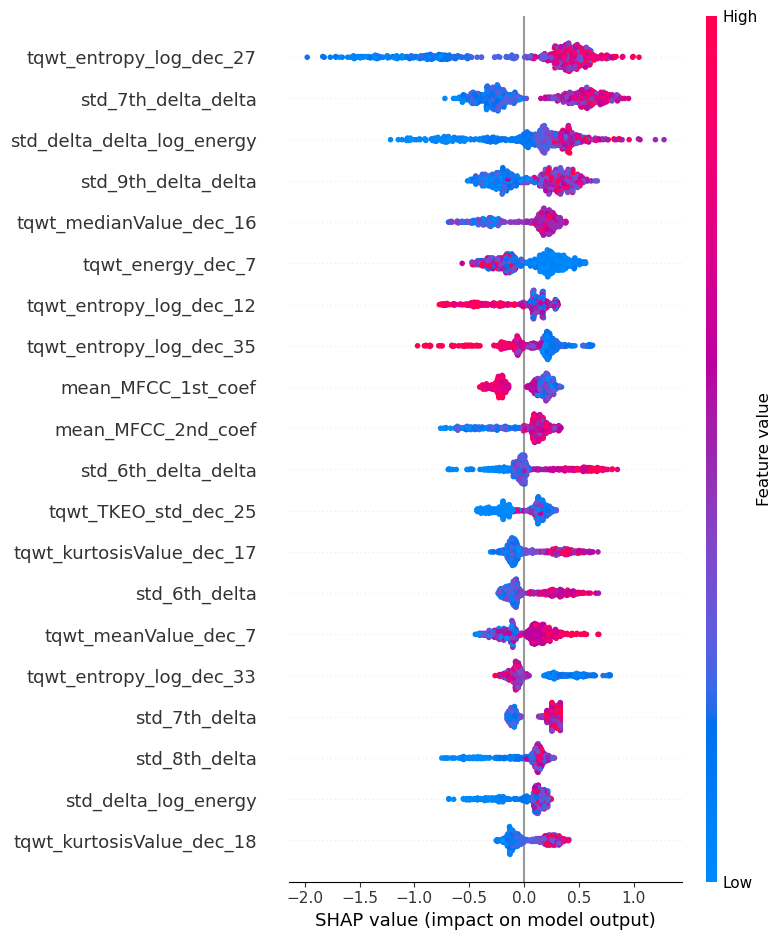


Top 20 Important Features:


tqwt_entropy_log_dec_27       0.572292
std_7th_delta_delta           0.420814
std_delta_delta_log_energy    0.351228
std_9th_delta_delta           0.274248
tqwt_medianValue_dec_16       0.249697
tqwt_energy_dec_7             0.243247
tqwt_entropy_log_dec_12       0.212294
tqwt_entropy_log_dec_35       0.207650
mean_MFCC_1st_coef            0.198937
mean_MFCC_2nd_coef            0.192903
std_6th_delta_delta           0.184713
tqwt_TKEO_std_dec_25          0.180949
tqwt_kurtosisValue_dec_17     0.180550
std_6th_delta                 0.178866
tqwt_meanValue_dec_7          0.176553
tqwt_entropy_log_dec_33       0.174381
std_7th_delta                 0.174130
std_8th_delta                 0.168759
std_delta_log_energy          0.163981
tqwt_kurtosisValue_dec_18     0.163560
dtype: float32

In [7]:
# Cell 6: Feature Importance Analysis
# Focus on XGBoost (best performing model)
best_model = models['XGBoost']

# Plot built-in feature importance
plt.figure(figsize=(10,8))
sorted_idx = best_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][-20:], best_model.feature_importances_[sorted_idx][-20:])
plt.xlabel("XGBoost Feature Importance")
plt.show()

# SHAP analysis
print("\nCalculating SHAP values... (this may take a few minutes)")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

# Summary plot (bar)
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="bar", max_display=20)
plt.show()

# Summary plot (dot)
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, max_display=20)
plt.show()

# Get top features
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_abs_mean = shap_df.abs().mean().sort_values(ascending=False)
top_features = shap_abs_mean.head(20).index.tolist()

print("\nTop 20 Important Features:")
display(shap_abs_mean.head(20))


Training final model with top 20 features...

Final Model Performance with Top 20 Features:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70        38
           1       0.88      0.96      0.91       112

    accuracy                           0.87       150
   macro avg       0.85      0.78      0.81       150
weighted avg       0.86      0.87      0.86       150

ROC-AUC Score: 0.9189


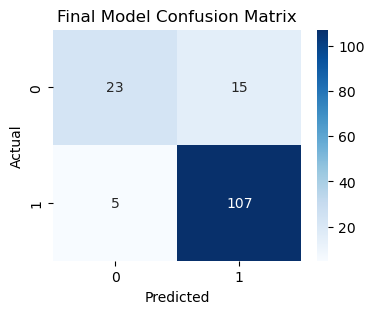

In [8]:
# Cell 7: Final Model with Top Features
# Select top features
X_train_top = X_train[top_features]

X_test_top = X_test[top_features]

# Scale top features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train final model
print("\nTraining final model with top 20 features...")
final_model = XGBClassifier(random_state=42, eval_metric='logloss')
final_model.fit(X_train_top_scaled, y_train)

# Evaluate final model
y_pred_final = final_model.predict(X_test_top_scaled)
y_proba_final = final_model.predict_proba(X_test_top_scaled)[:,1]

print("\nFinal Model Performance with Top 20 Features:")
print(classification_report(y_test, y_pred_final))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_final):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()